# Инициализация

Загружаем библиотеки необходимые для выполнения кода ноутбука.

In [ ]:
import logging

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
%config InlineBackend.figure_format = 'retina'

# === ЭТАП 1 ===

# Загрузка первичных данных

Загружаем первичные данные из файлов:
- tracks.parquet
- catalog_names.parquet
- interactions.parquet

In [8]:
tracks = pd.read_parquet("tracks.parquet")

In [9]:
catalog_names = pd.read_parquet("catalog_names.parquet")

In [10]:
interactions = pd.read_parquet("interactions.parquet")

# Обзор данных

Проверяем данные, есть ли с ними явные проблемы.
* Нужно ли изменить тип идентификаторов?
* Есть ли треки с неизвестными исполнителями, альбомами, жанрами?

### tracks (Данные о треках)
* track_id — идентификатор музыкального трека;
* albums — список идентификаторов альбомов, содержащих трек;
* artists — список идентификаторов исполнителей трека;
* genres — список идентификаторов жанров, к которым принадлежит трек.

In [11]:
tracks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 4 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   track_id  1000000 non-null  int64 
 1   albums    1000000 non-null  object
 2   artists   1000000 non-null  object
 3   genres    1000000 non-null  object
dtypes: int64(1), object(3)
memory usage: 30.5+ MB


In [27]:
tracks.sample(3)

,track_id,albums,artists,genres,n_albums,n_artists,n_genres
160973,4186453,"[473481, 1792953, 4998485]",[271058],"[11, 63]",3,1,2
375001,25242599,[2971720],[168862],"[3, 75]",1,1,2
697006,51320702,[7150691],[4360139],[12],1,1,1


In [32]:
# тип массивов
print(type(tracks.loc[0, 'albums']))
print(type(tracks.loc[0, 'artists']))
print(type(tracks.loc[0, 'genres']))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [33]:
# тип элементов массивов
print(type(tracks.loc[0, 'albums'][0]))
print(type(tracks.loc[0, 'artists'][0]))
print(type(tracks.loc[0, 'genres'][0]))

<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>


In [34]:
# функция для подсчета количества элементов
def len_list(l):
    return l.shape[0]

In [35]:
# вычислим длины массивов
tracks['n_albums'] = tracks['albums'].apply(len_list)
tracks['n_artists'] = tracks['artists'].apply(len_list)
tracks['n_genres'] = tracks['genres'].apply(len_list)

In [37]:
print('Кол-во записей нулевой длины в поле albums:', tracks[tracks['n_albums']==0]['track_id'].count())
print('Кол-во записей нулевой длины в поле artists:', tracks[tracks['n_artists']==0]['track_id'].count())
print('Кол-во записей нулевой длины в поле genres:', tracks[tracks['n_genres']==0]['track_id'].count())

Кол-во записей нулевой длины в поле albums: 18
Кол-во записей нулевой длины в поле artists: 15369
Кол-во записей нулевой длины в поле genres: 3687


In [39]:
tracks = tracks.query('n_albums > 0 and n_artists > 0 and n_genres > 0').reset_index(drop=True)

In [40]:
tracks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 980977 entries, 0 to 980976
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   track_id   980977 non-null  int64 
 1   albums     980977 non-null  object
 2   artists    980977 non-null  object
 3   genres     980977 non-null  object
 4   n_albums   980977 non-null  int64 
 5   n_artists  980977 non-null  int64 
 6   n_genres   980977 non-null  int64 
dtypes: int64(4), object(3)
memory usage: 52.4+ MB


In [41]:
print(f'Доля удаленных записей: {np.round(100 * (1000000 - 980977) / 1000000, 2)}%')

Доля удаленных записей: 1.9%


Проблемв в tracks присутствуют:
* пропусков нет, но есть записи с нулевым количеством элементов (самое большое их количество в поле artists - но это всего-лишь 1,9% от общего их числа и лучше удалить такие треки из рекомендательной базы чтобы улучшить ее качество;
* типы корректные.

### catalog_names (Имена артистов, названия альбомов, треков и жанров )
* id — идентификатор одной из каталожных единиц (трека, альбома, исполнителя, жанра);
* type — тип идентификатора;
* name — имя (название) каталожной единицы.

In [13]:
catalog_names.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1812471 entries, 0 to 1812470
Data columns (total 3 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   id      int64 
 1   type    object
 2   name    object
dtypes: int64(1), object(2)
memory usage: 41.5+ MB


In [14]:
catalog_names.sample(3)

,id,type,name
40464,144527,album,Habia Una Vez Un Circo
352728,6036266,album,Boogie Angst Edition Two
1024200,9303819,track,After the Lights Go Down Low


In [78]:

catalog_names['type'].unique()

array(['album', 'artist', 'genre', 'track'], dtype=object)

In [43]:
# почему-то тут не выдается информация о количестве записей, проверим по-другому
print('Кол-во пропусков в поле albums:', np.sum(catalog_names['id'].isnull()))
print('Кол-во пропусков в поле type:', np.sum(catalog_names['type'].isnull()))
print('Кол-во пропусков в поле name:', np.sum(catalog_names['name'].isnull()))

Кол-во пропусков в поле albums: 0
Кол-во пропусков в поле type: 0
Кол-во пропусков в поле name: 0


In [52]:
print('Кол-во нулей в поле id:', catalog_names[catalog_names['id']==0]['id'].count())
print('Кол-во пустых записей в поле track_id:', catalog_names[catalog_names['type']=='']['id'].count())
print('Кол-во пустых записей в поле track_seq:', catalog_names[catalog_names['name']=='']['id'].count())

Кол-во нулей в поле id: 1
Кол-во пустых записей в поле track_id: 0
Кол-во пустых записей в поле track_seq: 0


In [53]:
# скореее всего, ноль в в поле id корректный, т.к. он всего один

Проблемв в catalog_names отсутствуют:
* пропусков нет;
* типы корректные.

### interactions (Данные о том, какие пользователи прослушали тот или иной трек)
* user_id — идентификатор пользователя,
* track_id — идентификатор музыкального трека,
* track_seq — номер места трека в истории пользователя,
* started_at — дата начала прослушивания трека.

In [15]:
interactions.info()

<class 'pandas.core.frame.DataFrame'>
Index: 222629898 entries, 0 to 291
Data columns (total 4 columns):
 #   Column      Dtype         
---  ------      -----         
 0   user_id     int32         
 1   track_id    int32         
 2   track_seq   int16         
 3   started_at  datetime64[ns]
dtypes: datetime64[ns](1), int16(1), int32(2)
memory usage: 5.4 GB


In [16]:
interactions.sample(3)

,user_id,track_id,track_seq,started_at
971,1124344,49199931,972,2022-09-22
427,1038064,59345751,428,2022-09-26
41,189768,150001,42,2022-07-19


In [44]:
# почему-то тут не выдается информация о количестве записей, проверим по-другому
print('Кол-во пропусков в поле user_id:', np.sum(interactions['user_id'].isnull()))
print('Кол-во пропусков в поле track_id:', np.sum(interactions['track_id'].isnull()))
print('Кол-во пропусков в поле track_seq:', np.sum(interactions['track_seq'].isnull()))
print('Кол-во пропусков в поле started_at:', np.sum(interactions['started_at'].isnull()))

Кол-во пропусков в поле user_id: 0
Кол-во пропусков в поле track_id: 0
Кол-во пропусков в поле track_seq: 0
Кол-во пропусков в поле started_at: 0


In [46]:
print('Кол-во нулей в поле user_id:', interactions[interactions['user_id']==0]['user_id'].count())
print('Кол-во нулей в поле track_id:', interactions[interactions['track_id']==0]['user_id'].count())
print('Кол-во нулей в поле track_seq:', interactions[interactions['track_seq']==0]['user_id'].count())
print('Кол-во нулей в поле started_at:', interactions[interactions['started_at']==0]['user_id'].count())

Кол-во нулей в поле user_id: 26
Кол-во нулей в поле track_id: 0
Кол-во нулей в поле track_seq: 0
Кол-во нулей в поле started_at: 0


Проблемв в interactions присутствуют:
* пропусков нет, но есть нули в поле user_id - видимо, пропуски были заполнены нулями;
* индексы повторялись;
* типы корректные.

In [47]:
interactions = interactions.query('user_id != 0').reset_index(drop=True)

In [48]:
interactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 222629872 entries, 0 to 222629871
Data columns (total 4 columns):
 #   Column      Dtype         
---  ------      -----         
 0   user_id     int32         
 1   track_id    int32         
 2   track_seq   int16         
 3   started_at  datetime64[ns]
dtypes: datetime64[ns](1), int16(1), int32(2)
memory usage: 3.7 GB


In [51]:
print(f'Доля удаленных записей: {np.round(100 * (222629898 - 222629872) / 222629898, 6)}%')

Доля удаленных записей: 1.2e-05%


# Выводы

Приведём выводы по первому знакомству с данными:
- есть ли с данными явные проблемы,
- какие корректирующие действия (в целом) были предприняты.

* Типы идентификаторов корректные, в замене не нуждаются.
* Треки с отсутствующими записями были удалены.
* Записи о взаимодействиях с нулевыми идентификаторами пользовтаелей были удалены.

# === ЭТАП 2 ===

# EDA

### Распределение количества прослушанных треков.

<Axes: >

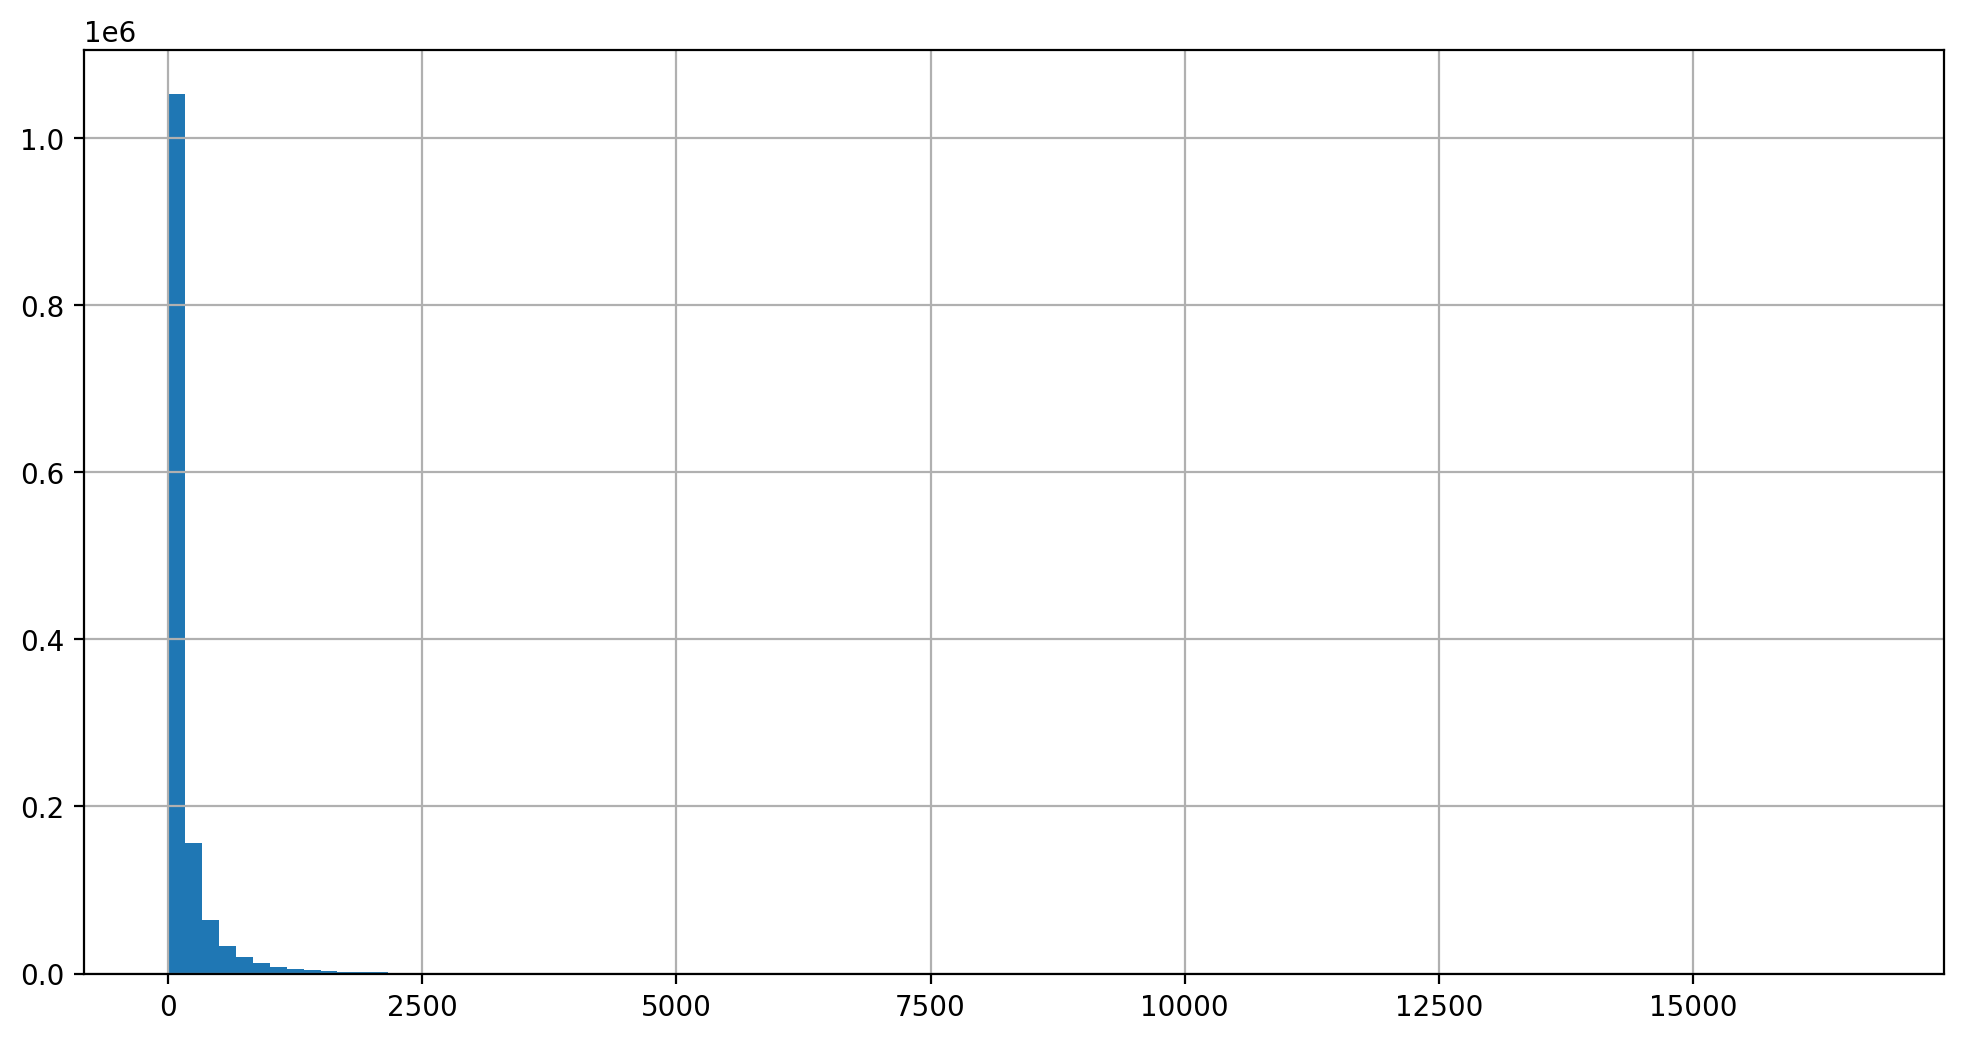

In [60]:
# трактую как - прослушанных треков каждым пользователем
interactions.groupby("user_id").agg(num=("track_id", "count"))['num'].hist(bins=100, figsize=(12, 6))

<Axes: >

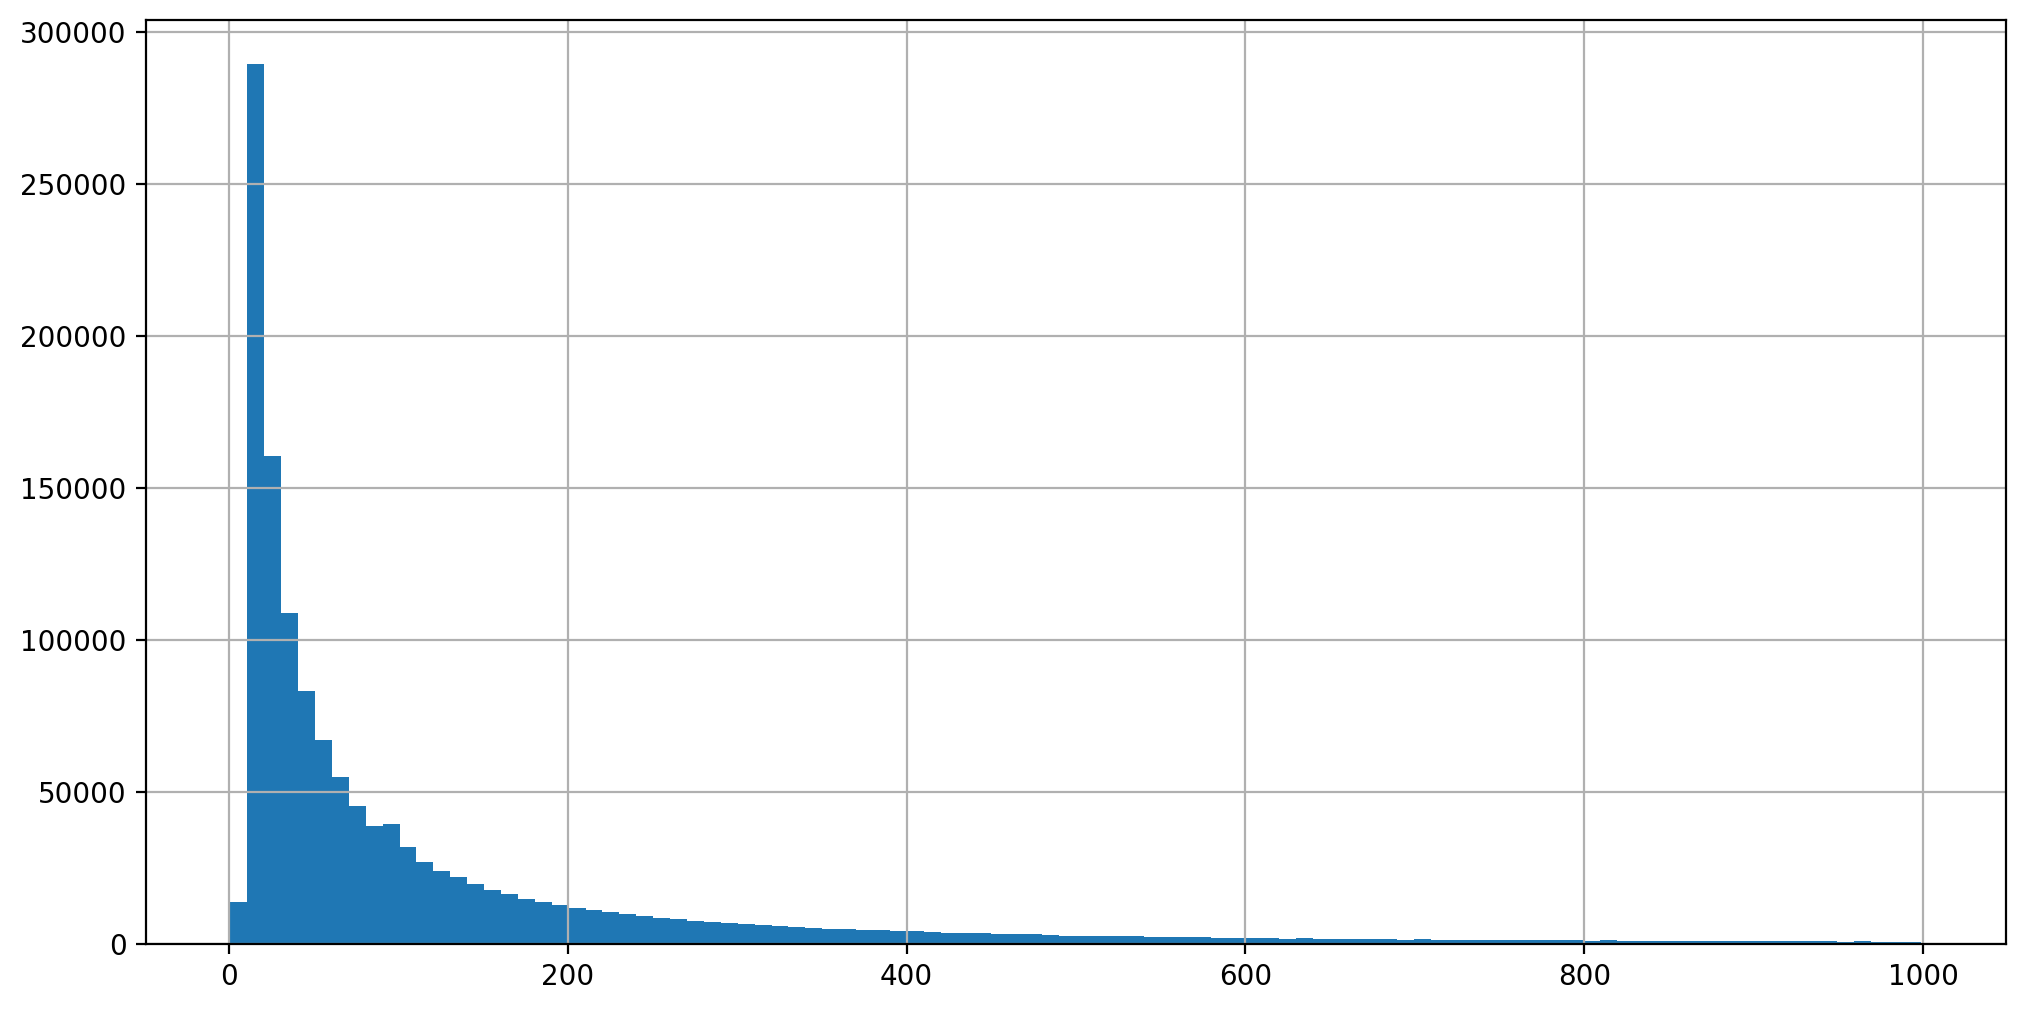

In [63]:
# видно, что основная часть распределения сосредоточена до 1000 - посмотрим боле побробно
interactions.groupby("user_id").agg(num=("track_id", "count")).query('num < 1000')['num'].hist(bins=100, figsize=(12, 6))

In [64]:
# т.е. в основном пользователи слушают одно и то же 

### Наиболее популярные треки

In [67]:
popular_tracks = interactions.groupby("track_id").agg(nunique=("user_id", "nunique"))

In [72]:
popular_tracks = popular_tracks.sort_values(by='nunique', ascending=False)

In [79]:
top_10_popular_tracks = popular_tracks[:10]

In [80]:
top_10_popular_tracks = top_10_popular_tracks.merge(tracks.drop(['n_albums', 'n_artists', 'n_genres'], axis=1), on='track_id', how='left')

In [81]:
# TOP-10 популярных трэков
top_10_popular_tracks

,track_id,nunique,albums,artists,genres
0,53404,111062,"[4367, 89708, 294911, 294912, 294914, 297393, ...",[9262],"[13, 14, 102]"
1,33311009,106921,"[4440454, 4456609, 4482682, 4882996, 5072976, ...",[675068],"[14, 102]"
2,178529,101924,"[18113, 21924, 21940, 488052, 10009799]",[36800],"[41, 47]"
3,35505245,99490,"[4431303, 20559909]","[4611844, 588511]","[3, 75]"
4,65851540,86670,[10692414],[1554548],"[11, 20]"
5,24692821,86246,"[2888516, 3523463, 3530199, 4333848, 4420934, ...",[1194096],[70]
6,32947997,85886,"[4019560, 4172930, 4172931, 5614201, 5933975]",[381067],[11]
7,51241318,85244,"[5239478, 13040087, 13131618, 15177310, 154524...","[1802873, 3135644, 9012818]",[74]
8,795836,85042,"[88770, 296297, 297576, 302579, 303469, 558376...",[680],"[11, 14, 102]"
9,45499814,84748,"[6109461, 7094821, 7152451, 7170954, 7285586, ...",[5007577],"[11, 20]"


In [97]:
for i in range(top_10_popular_tracks.shape[0]):
    print(f'Информация по треку на месте N-{i+1} в TOP-10:')
    track_id = top_10_popular_tracks.loc[i, 'track_id']
    print('-- Трэк:', catalog_names.query('id==@track_id and type=="track"')['name'].tolist()[0])
    
    artists = top_10_popular_tracks.loc[i, 'artists']
    artists_list = []
    for artist in artists:
        artists_list.append(catalog_names.query('id==@artist and type=="artist"')['name'].tolist()[0])
    print('-- Исполнители:', ', '.join(artists_list))

    genres = top_10_popular_tracks.loc[i, 'genres']
    genres_list = []
    for genre in genres:
        genres_list.append(catalog_names.query('id==@genre and type=="genre"')['name'].tolist()[0])
    print('-- Жанры:', ', '.join(genres_list))
    
    print('')    

Информация по треку на месте N-1 в TOP-10:
-- Трэк: Smells Like Teen Spirit
-- Исполнители: Nirvana
-- Жанры: alternative, rock, allrock

Информация по треку на месте N-2 в TOP-10:
-- Трэк: Believer
-- Исполнители: Imagine Dragons
-- Жанры: rock, allrock

Информация по треку на месте N-3 в TOP-10:
-- Трэк: Numb
-- Исполнители: Linkin Park
-- Жанры: numetal, metal

Информация по треку на месте N-4 в TOP-10:
-- Трэк: I Got Love
-- Исполнители: Miyagi & Эндшпиль, Рем Дигга
-- Жанры: rusrap, rap

Информация по треку на месте N-5 в TOP-10:
-- Трэк: Юность
-- Исполнители: Dabro
-- Жанры: pop, ruspop

Информация по треку на месте N-6 в TOP-10:
-- Трэк: Way Down We Go
-- Исполнители: KALEO
-- Жанры: indie

Информация по треку на месте N-7 в TOP-10:
-- Трэк: Shape of You
-- Исполнители: Ed Sheeran
-- Жанры: pop

Информация по треку на месте N-8 в TOP-10:
-- Трэк: In The End
-- Исполнители: Tommee Profitt, Fleurie, Mellen Gi
-- Жанры: rnb

Информация по треку на месте N-9 в TOP-10:
-- Трэк: Shap

### Наиболее популярные жанры

In [ ]:
# снчала для удобства сделаем отдельный каталог жанров
genres_df = catalog_names[catalog_names['type']=='genre'].reset_index(drop=True)

In [ ]:
genres_df.info()

### Треки, которые никто не прослушал

# Преобразование данных

Преобразуем данные в формат, более пригодный для дальнейшего использования в расчётах рекомендаций.

# Сохранение данных

Сохраним данные в двух файлах в персональном S3-бакете по пути `recsys/data/`:
- `items.parquet` — все данные о музыкальных треках,
- `events.parquet` — все данные о взаимодействиях.

# Очистка памяти

Здесь, может понадобится очистка памяти для высвобождения ресурсов для выполнения кода ниже. 

Приведите соответствующие код, комментарии, например:
- код для удаление более ненужных переменных,
- комментарий, что следует перезапустить kernel, выполнить такие-то начальные секции и продолжить с этапа 3.

# === ЭТАП 3 ===

# Загрузка данных

Если необходимо, то загружаем items.parquet, events.parquet.

# Разбиение данных

Разбиваем данные на тренировочную, тестовую выборки.

# Топ популярных

Рассчитаем рекомендации как топ популярных.

# Персональные

Рассчитаем персональные рекомендации.

# Похожие

Рассчитаем похожие, они позже пригодятся для онлайн-рекомендаций.

# Построение признаков

Построим три признака, можно больше, для ранжирующей модели.

# Ранжирование рекомендаций

Построим ранжирующую модель, чтобы сделать рекомендации более точными. Отранжируем рекомендации.

# Оценка качества

Проверим оценку качества трёх типов рекомендаций: 

- топ популярных,
- персональных, полученных при помощи ALS,
- итоговых
  
по четырем метрикам: recall, precision, coverage, novelty.

# === Выводы, метрики ===

Основные выводы при работе над расчётом рекомендаций, рассчитанные метрики.